<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S63_driving_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

In [2]:
import math
import numpy as np
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam 
from gtbook import driving

# Sensing for Autonomous Vehicles

> LIDAR once, LIDAR twice...

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(6, 3, "steampunk", 1))

## LIDAR

LIDAR (LIght raDAR) is a technology that measures distance to an object by using laser light and the "Time of Flight" or **ToF** principle. There are several variants in use, and the simplest to explain is the **direct ToF** sensor, which sends out a short pulse and measures the elapsed time $\Delta t$ for the light to bounce off an abject and return to a detector collocated with the laser pulse emitter. If the object is situated at a distance $d$, we then have

$$
\Delta t = \frac{2 d}{c} 
$$

where $c\approx300,000km/s$ is the speed of light. For example, for an object at 15m, we have 

$$
\Delta t \approx \frac{2 \times 0.015}{300,000} = 0.1\mu s
$$

Assuming we can measure $\Delta t$ accurately, we can then easily compute the distance:

$$
d= c\frac{\Delta t}{2}
$$

In a *scanning LIDAR*, there is typically one detector, whereas in a *flash LIDAR* a single pulse is emitted in a wide field of view, and an *array* of detectors, akin to a CCD sensor, is used to detect the returning light pulses in multiple directions at once.

However, *indirect* time of flight sensors are more prevalent in robotics and autonomous driving applications. Unfortunately, measuring elapsed times at the nano-second scale is difficult and expensive, and the amount of light energy that needs to be emitted for direct ToF can also be a problem from an eye-safety perspective. Hence, a more widely used principle is **indirect ToF**, where the light is emitted with a waveform, e.g., a sine wave, and the returned light is correlated with the amplitude of the emitted light to calculate a phase-shift. The elapsed time $\Delta t$ and distance $d$ can then be calculated from the phase-shift.

Two common scanning LIDAR technologies are in use for robotics: **2D LIDAR**, which consists of a single laser beam that is rotated around a fixed axis, and **3D LIDAR**, which has multiple laser/detector pairs rotated at different inclinations. 2D LIDARs are also often deployed on aircraft to create highly detailed digital elevation maps (DEMs), where the 3D dimension is provided by the aircraft's forward motion. Finally, LIDAR altimeters are even deployed from satellites in orbit around Earth or [other planets](https://pgda.gsfc.nasa.gov/products/62).

## Ray Intersection

> Intersecting rays is as easy as a dot product

To perform inference about the environment with LIDAR, we have to model how LIDAR beams interact with it, which in the case of polygonal objects comes down to line-line or line-plane intersections.

We examine the 2D line-line intersection case first. Assume we have a line in 2D with equation $\hat{n} \cdot p = d$, where $\hat{n}$ is a normal vector and $d>0$ is the distance of the line to the origin. The hat notation signifies that the normal vector $\hat{n}$ is normalized to length 1. Then if we have a ray of points $p = \hat{r} s$ where $\hat{r}$ is the **ray direction** and $s>0$ is a scalar, then we can find the intersection by plugging the ray equation into the line equation

$$
\hat{n} \cdot (\hat{r} s) = d,
$$

where $a \cdot b \doteq a^T b = b^T a$ is the standard vector dot product. We find the range $s$ to the object as:

$$
s = \frac{d}{\hat{n} \cdot \hat{r}}.
$$

We can ensure that $s>0$ and avoid a division by zero by checking the dot product before doing the division:

$$
\hat{n} \cdot \hat{r} > 0
$$

The following code implements this code:

In [4]:
def intersect(n, d, r):
    """Intersect line/plane (n,d) with ray given by direction r."""
    cos = np.dot(n,r)
    return d / cos if cos>0 else float('nan')

assert intersect(n=gtsam.Point2(1,0), d=5, r=gtsam.Point2(1,0)) == 5

The story above generalizes *completely* to 3D, where with $\hat{n}\in\mathbb{R}^3$ and $p\in\mathbb{R}^3$ the equation $\hat{n} \cdot p = d$ defines a *plane* in 3D:

In [5]:
assert intersect(n=gtsam.Point3(1,0,0), d=5, r=gtsam.Point3(1,0,0)) == 5

## Simulating a 2D LIDAR

> Use the intersection, Luke!

We now put the above to work to simulate a 2D LIDAR sensor situated at the origin. A relatively low-cost 2D LIDAR sensor is a SICK Tim1xx, which has a field of view of 200 degrees and a resolution of one beam per degree. Hence, we expect to simulate 200 measurements.

In our simple simulation code below, we create an environment from infinite lines. A more powerful simulator would allow for line *segments*, but infinite lines are enough to illustrate the principle. We create a corridor-like environment with three sides:

In [6]:
north = gtsam.Point2(0,1), 2.5
east = gtsam.Point2(1,0), 8
south = gtsam.Point2(0,-1), 2.5

Then we simply create 200 rays, ranging from -100 degrees to 100 degrees, with 0 facing due east:

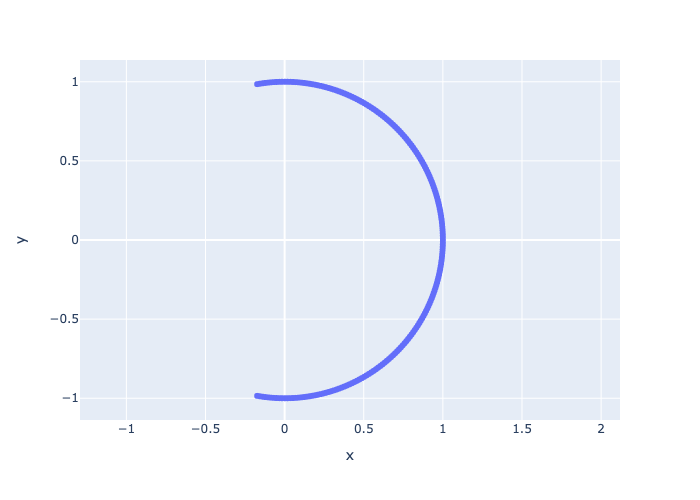

In [7]:
angles = np.linspace(-100, 100, 200)
rays = np.array([gtsam.Rot2(math.radians(angle)).matrix()[0,:] for angle in angles])
fig = px.scatter(x=rays[:,0],y=rays[:,1])
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

Finally, we do the intersection:

In [8]:
scan = []
for r in rays:
    ranges = [intersect(n,d,r) for n, d in [north, east, south]]
    _range = np.nanmin(ranges)
    intersection = _range * r
    scan.append(intersection)

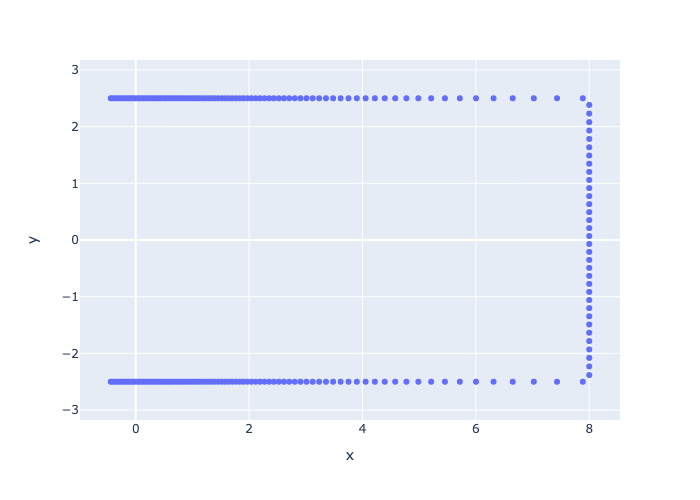

In [9]:
scan_x, scan_y = zip(*scan)
fig = px.scatter(x=scan_x, y=scan_y)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

As you can see, the resulting scan of this corridor-like environment does not yield in a uniform sampling on the walls. Because the rays are distributed uniformly in *angle* space, they graze the walls at increasingly shallow angles, and the distance between successive intersection points increases. Of course, that depends on the angle that the wall makes with the rays: the end of the corridor is far away and hence is sampled fairly uniformly. This is a typical pattern when working with LiDAR scanners.

## Geometry of a Moving LIDAR

Above we assumed that the ray is situated at the *world* origin, but we can also generalize to the case where the rays are defined in a *body coordinate frame* $(R^w_b,t^w_b)$. In this case, it is convenient to transform the plane to the body frame. We can do this by expressing a point $p^w$ in world coordinates as a function of a point in body coordinates: $p^w = R^w_b p^b + t^w_b$ and plugging that into the plane equation:

$$
\begin{align*}
\hat{n}^w \cdot p^w &= d^w \\
\hat{n}^w \cdot \{ R^w_b p^b + t^w_b \} &= d^w \\
(R^w_b)^T \hat{n}^w \cdot p^b &= d^w - \hat{n}^w \cdot t^w_b.
\end{align*}
$$

Hence, we obtained a new plane equation in the body frame as
$$
\hat{n}^b \cdot p^b = d^b
$$

with transformed plane parameters $\hat{n}^b \doteq (R^w_b)^T \hat{n}^w$ and $d^b \doteq d^w - \hat{n}^w \cdot t^w_b$.

We can use a  `gtsam.Pose2` or `gtsam.Pose3` object to specify the body frame, respectively in 2D or 3D, and then use it to transform plane coordinates:

In [10]:
def transform_to(n, d, wTb):
    """Transform line/plane (n,d) to body coordinate frame"""
    wRb = wTb.rotation()
    wtb = wTb.translation()
    return wRb.matrix().T @ n, d - np.dot(n, wtb)

We can do this for lines in 2D

In [11]:
wTb = gtsam.Pose2(r=gtsam.Rot2(math.radians(20)), t=[2,1])
print(transform_to(gtsam.Point2(1,0), 5, wTb))

(array([ 0.93969262, -0.34202014]), 3.0)


and for planes in 3D:

In [12]:
wTb3 = gtsam.Pose3(r=gtsam.Rot3.Yaw(math.radians(45)), t=[1,2,3])
print(transform_to(gtsam.Point3(1,0,0), 5, wTb3))

(array([ 0.70710678, -0.70710678,  0.        ]), 4.0)


With this new functionality we can transform the world model and predict what the scan will look like, in body coordinates.

In [13]:
scan2 = []
transformed = [transform_to(n, d, wTb) for n, d in [north, east, south]]
for r in rays:
    ranges = [intersect(n,d,r) for n, d in transformed]
    _range = np.nanmin(ranges)
    intersection = _range * r
    scan2.append(intersection)

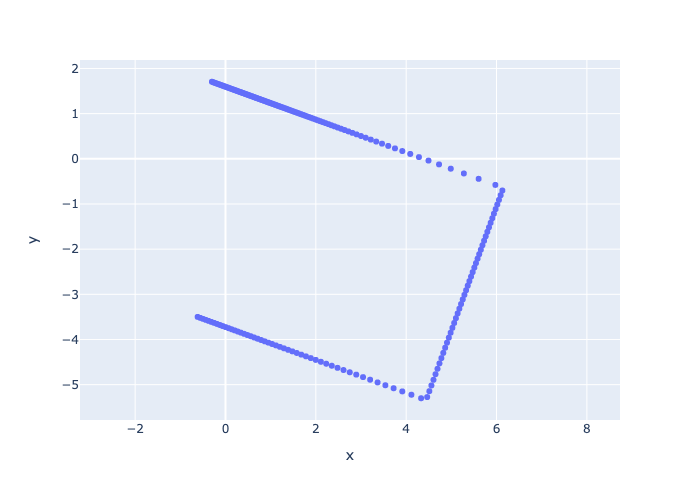

In [14]:
scan2_x, scan2_y = zip(*scan2)
fig = px.scatter(x=scan2_x, y=scan2_y)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

As you can see above, when the robot rotates 20 degrees *counter-clockwise*, the resulting scan in body coordinates seems to be rotated 20 degrees in the *opposite* direction. This makes sense! The forward direction for the robot is along the horizontal X-axis, and as you can see in the scan, the robot seems to be "looking" at the correct (upper-right) corner of our little hallway example. This perhaps counter-intuitive behavior is something to always keep in mind when looking at animations of LIDAR scans.

## Real LIDAR Scans

> From theory to practice.

3D LIDAR sensors are used in many autonomous driving efforts, e.g., by Waymo, Cruise, Argo, etc. Below we explore some real scans from the [Argoverse 2 Lidar Dataset](https://www.argoverse.org/av2.html).

First, let us look at a single scan, which was acquired using a [Velodyne](https://velodynelidar.com/products/ultra-puck/) VLP-32C LIDAR sensor. If you follow the link you see some cool animations of sensor in action, in real traffic. The `32` in the model name reflects the fact for this particular sensor used by Argo, there are 32 separate laser beams at different inclinations, that spin around for a full 360 degree field of view. In this case, the inclination angles are uniformly sampled between -25 and +15 degrees with respect to horizontal, but of course this depends on the application/sensor model.

Several things worth noting when looking at the single scan below, taken when the Argo test car is turning at an intersection:
- the location of the car (at the origin) is marked by concentric circles formed by the lowest beams.
- the range is approximately 200m, so we can see fairly far down the cross streets.
- occlusion is significant: objects close to the car throw "occlusion shadows".
- everything is in *body coordinates*, and the fact that the streets appear rotated betrays that the car is actually turning.

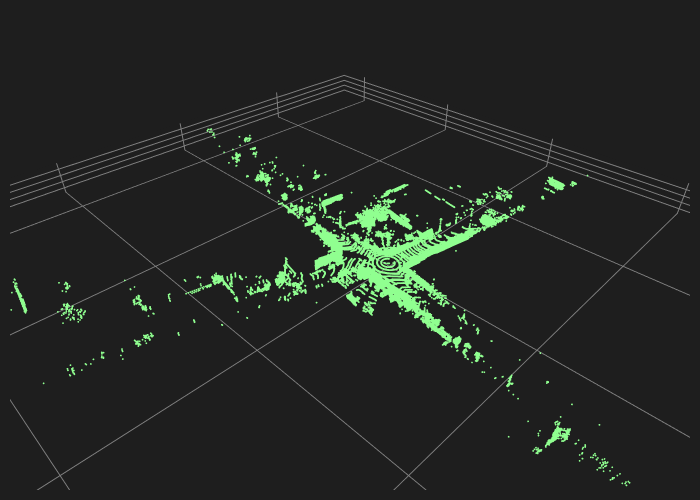

In [15]:
real_scans = {0:driving.read_lidar_points('Figures6/lidar/PC_315967795019746000.ply')}
driving.visualize_cloud(real_scans[0], show_grid_lines=True)

We can also learn some things from looking at two successive scans below. 
The scans are slightly rotated and translated from each other, and this will be exactly how we can infer the ego-motion of the car in the next section.

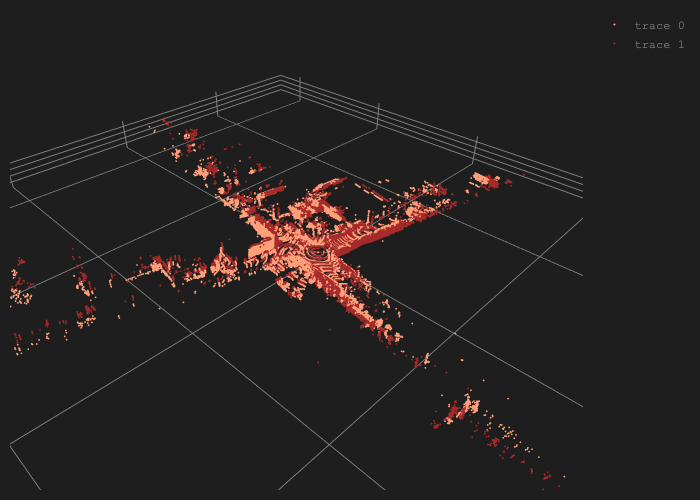

In [16]:
real_scans[1] = driving.read_lidar_points('Figures6/lidar/PC_315967795520065000.ply')
driving.visualize_clouds([real_scans[0],real_scans[1]], show_grid_lines=True)

Finally, let us look at scans that are taken a bit further apart, in this case there are 8 scans that we skipped:

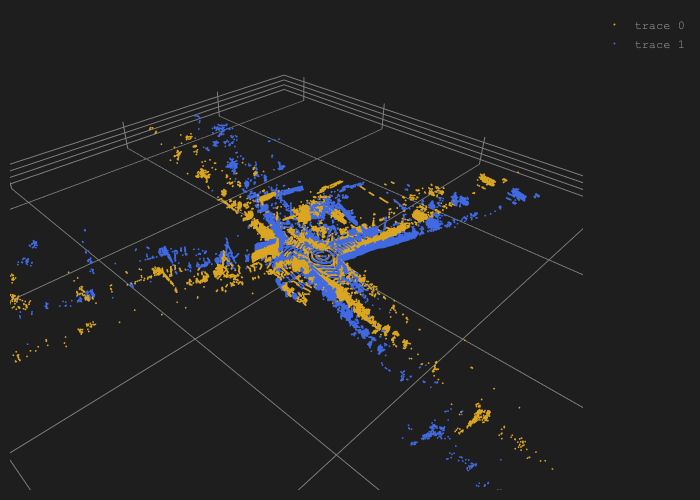

In [17]:
real_scans[9] = driving.read_lidar_points('Figures6/lidar/PC_315967795919523000.ply')
driving.visualize_clouds([real_scans[0],real_scans[9]], show_grid_lines=True)

By inspecting (you can do this interactively in the colab) you can see that the car is *still* turning, but as the two scans are further apart the "mis-alginment" is more pronounced.

## Creating 3D Maps

> Blast points in 3D space!

If we know the exact pose at which a LIDAR scan was taken, we can transform the points in the scan into absolute coordinates, and create an extended **point cloud map** of the environment. In math, suppose we *know* that a scan was taken at $T^w_b$, then we can transform all LIDAR points $P^b$, which are given in body coordinates, to world coordinates:

$$
P^w = \phi(T^w_b, P^b)
$$

where $\phi$ the the action of $SE(3)$ on points in $\mathbb{R}^3$. Earlier in this chapter we saw this can be done by a matrix multiplication, by embedding points in $\mathbb{R}^4$, but GTSAM actually implements $\phi$ directly as `Pose3::transformFrom`. This method can be applied to a single `Point3` (just a $3\times 1$ vector, really) or on many points simultaneously, by passing in a $3\times N$ matrix:


In [19]:
scan_in_world = wTb3.transformFrom(real_scans[0])
print(scan_in_world.shape)

(3, 86651)


We will use this capability in the next section to produce large scale sparse point cloud maps of the environment around an autonomous vehicle.